# Simple

Demonstrates some of the complexities involved with implementing a very simple trading strategy.

## Environment

You will have to follow these steps before launching Jupyter

* Install Miniconda from https://docs.conda.io/en/latest/miniconda.html
    * `wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh`
    * `bash Miniconda3-latest-Linux-x86_64.sh -b`
    * `source ~/miniconda3/bin/activate'
* Install the Roq Python package from https://roq-trading.com/conda/unstable
    * `conda install --override-channels --channel defaults --channel https://roq-trading.com/conda/unstable roq-python roq-data`

## Configuration

In [1]:
HISTORY = 'USTP_Multi_20180223.csv'  # provided by the roq-data package

In [2]:
ACCOUNT = 'A1'                       # not really important unless you switch to trading

In [3]:
EXCHANGE = 'CFFEX'                   # China Financial Futures EXchange
SYMBOL = 'IC1803'                    # the most liquid instrument (on the specific trading day)

## Boilerplate

In [4]:
%matplotlib inline

In [5]:
import roq

In [6]:
def milliseconds(ms):
    import datetime
    return datetime.timedelta(milliseconds=ms)

In [7]:
def get_data_path(filename):
    """ Helper function to work out the full path for an installed example dataset. """
    import os
    return os.path.join(
        os.environ['CONDA_DIR'],
        *'share/roq/data'.split('/'),
        filename)

## Strategy

The strategy implementation implements event handling: processing may change state.

Example:
It should not be possible to create orders unless the market status has been received and it's open for trading.

In [8]:
class Strategy(roq.client.Handler):
    """
    A simple strategy implementing the client interface.
    """

    def __init__(
            self,
            account: str,
            exchange: str,
            symbol: str):
        """
        Constructor
        """
        roq.client.Handler.__init__(self)  # important! see pybind11 doc
        self.account = account
        self.exchange = exchange
        self.symbol = symbol
        self.counter = 0
        self.order_id = 0
        self.downloading = False
        self.order_manager_ready = False
        self.market_data_ready = False
        self.market_open = False

    def on_connection_status(
            self,
            source: int,
            source_name: str,
            connection_status: roq.ConnectionStatus):
        """ Event handler """
        if connection_status == roq.ConnectionStatus.CONNECTED:
            print('Connected')
            self.subscribe(
                accounts={
                    self.account,
                },
                symbols_by_exchange={
                    self.exchange: {
                        self.symbol,
                    },
                },
                source=source)
        elif connection_status == roq.ConnectionStatus.DISCONNECTED:
            print('Disconnected')
            self.order_manager_ready = False
            self.market_data_ready = False
            self.market_open = False

    def on_market_data_status(
            self,
            message_info: roq.MessageInfo,
            market_data_status: roq.MarketDataStatus):
        """ Event handler """
        if market_data_status.status == roq.GatewayStatus.READY:
            print('Market data is ready')
            self.market_data_ready = True
        elif market_data_status.status == roq.GatewayStatus.READY:
            print('Market data is *not* ready')
            self.market_data_ready = False
            self.market_open = False

    def on_order_manager_status(
            self,
            message_info: roq.MessageInfo,
            order_manager_status: roq.OrderManagerStatus):
        """ Event handler """
        if order_manager_status.account != self.account:
            return
        if order_manager_status.status == roq.GatewayStatus.READY:
            print('Order manager is ready')
            self.order_manager_ready = True
        elif order_manager_status.status == roq.GatewayStatus.READY:
            print('Order manager is *not* ready')
            self.order_manager_ready = False

    def on_download_begin(
            self,
            message_info: roq.MessageInfo,
            download_begin: roq.DownloadBegin):
        """ Event handler """
        self.downloading = True
        if len(download_begin.account) == 0:
            print('Downloading market data ...')
        elif download_begin.account == self.account:
            print('Downloading order manager data ...')

    def on_download_end(
            self,
            message_info: roq.MessageInfo,
            download_end: roq.DownloadEnd):
        """ Event handler """
        self.downloading = False
        if len(download_end.account) == 0:
            print('Market data download has completed')
        elif download_end.account == self.account:
            print('Order manager download has completed')
            if download_end.max_order_id > self.order_id:
                self.order_id = download_end.max_order_id
                print('Update: order_id={}'.format(self.order_id))

    def on_reference_data(
            self,
            message_info: roq.MessageInfo,
            reference_data: roq.ReferenceData):
        """ Event handler """
        pass

    def on_market_status(
            self,
            message_info: roq.MessageInfo,
            market_status: roq.MarketStatus):
        """ Event handler """
        if market_status.trading_status == roq.TradingStatus.OPEN:
            print('Market is open for trading')
            self.market_open = True
        else:
            print('Market is *not* open for trading')
            self.market_open = False

    def on_market_by_price(
            self,
            message_info: roq.MessageInfo,
            market_by_price: roq.MarketByPrice):
        """ Event handler """
        pass

    def on_trade_summary(
            self,
            message_info: roq.MessageInfo,
            trade_summary: roq.TradeSummary):
        """ Event handler """
        self.counter += 1
        if self.counter < 20:
            print('TradeSummary: time={} price={}'.format(
                int(message_info.source_receive_time.total_seconds() * 1e9),
                trade_summary.price))
        if self.counter == 9:
            self._create_order(
                side=roq.Side.BUY,
                quantity=1,
                limit_price=trade_summary.price,
                position_effect=roq.PositionEffect.OPEN,
                order_template="GTC"
            )
        if self.counter == 20:
            self._create_order(
                side=roq.Side.SELL,
                quantity=1,
                limit_price=trade_summary.price,
                position_effect=roq.PositionEffect.CLOSE,
                order_template="GTC"
            )
            
    def on_position_update(
            self,
            message_info: roq.MessageInfo,
            position_update: roq.PositionUpdate):
        """ Event handler """
        pass

    def on_order_update(
            self,
            message_info: roq.MessageInfo,
            order_update: roq.OrderUpdate):
        """ Event handler """
        print('OrderUpdate: order_id={} order_status={} remaining_quantity={}'.format(
            order_update.order_id, order_update.order_status, order_update.remaining_quantity))

    def on_trade_update(
            self,
            message_info: roq.MessageInfo,
            trade_update: roq.TradeUpdate):
        """ Event handler """
        print('TradeUpdate: trade_id={} order_id={} side={} quantity={} price={}'.format(
            trade_update.trade_id, trade_update.order_id, trade_update.side, trade_update.quantity, trade_update.price))

    def on_create_order_ack(
            self,
            message_info: roq.MessageInfo,
            create_order_ack: roq.CreateOrderAck):
        """ Event handler """
        print('CreateOrderAck: order_id={} failure={} reason={}'.format(
            create_order_ack.order_id, create_order_ack.failure, create_order_ack.reason))

    def on_modify_order_ack(
            self,
            message_info: roq.MessageInfo,
            modify_order_ack: roq.ModifyOrderAck):
        """ Event handler """
        pass

    def on_cancel_order_ack(
            self,
            message_info: roq.MessageInfo,
            cancel_order_ack: roq.CancelOrderAck):
        """ Event handler """
        pass
    
    def _create_order(
            self,
            side: roq.Side,
            quantity: float,
            limit_price: float,
            position_effect: roq.PositionEffect,
            order_template: str):
        """ Utility function to create orders. """
        if self.downloading or not self.market_open or not self.order_manager_ready:
            print('Can *not* trade!')
            return
        self.order_id += 1
        print('CreateOrder: order_id={} side={} quantity={} limit_price={}'.format(
             self.order_id, side, quantity, limit_price))
        try:
            self.create_order(
                account=self.account,
                order_id=self.order_id,
                exchange=self.exchange,
                symbol=self.symbol,
                side=side,
                quantity=quantity,
                order_type=roq.OrderType.LIMIT,
                limit_price=limit_price,
                time_in_force=roq.TimeInForce.GTC,
                position_effect=position_effect,
                order_template=order_template,
                source=0)
            return self.order_id
        except roq.NotReady:
            pass  # a hint: likely you're not correctly tracking the 'ready' state
        except roq.NotConnected:
            pass  # always a possibility

## Simulation

In [9]:
simulator = roq.client.Simulator(
    connections=[get_data_path(HISTORY),],
    sample_frequency=milliseconds(1),
    market_data_latency=milliseconds(100),
    order_manager_latency=milliseconds(500))

In [10]:
result = simulator.dispatch(
    Strategy,
    account=ACCOUNT,
    exchange=EXCHANGE,
    symbol=SYMBOL)

Connected
Order manager is ready
Order manager download has completed
Update: order_id=1000
Market data is ready
Market is open for trading
TradeSummary: time=1519378161928698112 price=5830.0
TradeSummary: time=1519378221872322048 price=5830.0
TradeSummary: time=1519378222384429824 price=5830.0
TradeSummary: time=1519378222900975104 price=5830.0
TradeSummary: time=1519378223404475904 price=5829.0
TradeSummary: time=1519378223919837952 price=5829.0
TradeSummary: time=1519378224442188032 price=5829.2
TradeSummary: time=1519378224861291776 price=5829.2
TradeSummary: time=1519378225381735936 price=5829.0
CreateOrder: order_id=1001 side=Side.BUY quantity=1 limit_price=5829.0
CreateOrderAck: order_id=1001 failure=False reason=
OrderUpdate: order_id=1001 order_status=OrderStatus.WORKING remaining_quantity=1.0
TradeSummary: time=1519378225904634112 price=5829.2
TradeSummary: time=1519378226425105152 price=5829.0
TradeUpdate: trade_id=1 order_id=1001 side=Side.BUY quantity=1.0 price=5829.0
Orde

## Results

In [11]:
reference_data = result.extract(kind="reference_data")
reference_data

,,,tick_size,limit_up,limit_down,multiplier
time,exchange,symbol,,,,
1519378161928698184,CFFEX,IC1803,0.2,0.0,0.0,0.0


In [12]:
market_status = result.extract(kind="market_status")
market_status

,,,trading_status
time,exchange,symbol,
1519378161928698184,CFFEX,IC1803,OPEN


In [13]:
trade_summary = result.extract(kind="trade_summary")
trade_summary.head()

,,,price,volume
time,exchange,symbol,,
1519378161928000000,CFFEX,IC1803,5830.0,20.0
1519378221872000000,CFFEX,IC1803,5830.0,14.0
1519378222384000000,CFFEX,IC1803,5830.0,3.0
1519378222900000000,CFFEX,IC1803,5830.0,2.0
1519378223404000000,CFFEX,IC1803,5829.0,1.0


In [14]:
market_by_price = result.extract(kind='market_by_price')
market_by_price.head(20)

price  quantity
time                exchange symbol                  
1519378161928000000 CFFEX    IC1803  5834.0      -5.0
                             IC1803  5837.8      -1.0
                             IC1803  5831.0      -1.0
                             IC1803  5821.0       1.0
                             IC1803  5825.0       1.0
                             IC1803  5820.2       1.0
                             IC1803  5830.0      -8.0
                             IC1803  5820.0       1.0
                             IC1803  5836.0      -1.0
                             IC1803  5819.0       1.0
1519378221872000000 CFFEX    IC1803  5834.0      -5.0
                             IC1803  5837.8      -1.0
                             IC1803  5831.0      -1.0
                             IC1803  5823.0       5.0
                             IC1803  5824.0       5.0
                             IC1803  5829.0       5.0
                             IC1803  5825.0       6.0
                             IC1803  5821.0       0.0
                             IC1803  5820.2       0.0
                             IC1803  5836.8      -5.0

In [15]:
top_of_book = result.extract(kind='top_of_book')
top_of_book.head()

,,,bid,ask
time,exchange,symbol,,
1519378161928000000,CFFEX,IC1803,5825.0,5830.0
1519378221872000000,CFFEX,IC1803,5830.0,5831.0
1519378222384000000,CFFEX,IC1803,5829.0,5830.0
1519378222900000000,CFFEX,IC1803,5829.0,5830.0
1519378223404000000,CFFEX,IC1803,5829.0,5829.4


In [16]:
create_order = result.extract(kind='create_order')
create_order

,,,,order_type,time_in_force,side
time,exchange,symbol,order_id,,,
1519378230966798031,CFFEX,IC1803,1002,LIMIT,GTC,SELL
1519378225381736785,CFFEX,IC1803,1001,LIMIT,GTC,BUY


In [17]:
order_update = result.extract(kind='order_update')
order_update

,,,,order_status,limit_price,remaining_quantity,traded_quantity
time,exchange,symbol,order_id,,,,
1519378225381736785,CFFEX,IC1803,1001,WORKING,5829.0,1.0,0.0
1519378226425105125,CFFEX,IC1803,1001,COMPLETED,5829.0,0.0,1.0
1519378230966798031,CFFEX,IC1803,1002,WORKING,5829.0,1.0,0.0
1519378301396991737,CFFEX,IC1803,1002,COMPLETED,5829.0,0.0,1.0


In [18]:
trade_update = result.extract(kind='trade_update')
trade_update

,,,,,quantity,price
time,exchange,symbol,order_id,trade_id,,
1519378301396991737,CFFEX,IC1803,1002,2,1.0,5829.0
1519378226425105125,CFFEX,IC1803,1001,1,1.0,5829.0


## Charts

In [19]:
def get_range(df, idx_0, idx_1):
    tmp = df.index.get_level_values(0)[idx_0:idx_1]
    return (tmp[0], tmp[-1])

In [20]:
def select_subset(df, time_0, time_1):
    import numpy as np
    include = np.logical_and(
        df.index.get_level_values(0) >= time_0,
        df.index.get_level_values(0) <= time_1)
    tmp = df[include]
    # drop from index
    names_to_remove = ('exchange', 'symbol')
    index_names = [name for name in tmp.index.names if name not in names_to_remove]
    if len(index_names) == len(tmp.index.names):
        return tmp
    return tmp.reset_index().drop(columns=list(names_to_remove)).set_index(index_names)

In [21]:
def plot_data(big_size, reference_data, trade_summary, market_by_price, top_of_book, create_order, order_update):
    """ Utility function to plot order book, traded volume and best bid/ask on the same chart. """
    import numpy as np
    import pandas as pd
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(16,10))
    # represent all ticks within the range
    tick_size = reference_data['tick_size'].values[0]
    time = market_by_price.index.get_level_values('time').values
    price = market_by_price['price'].values
    quantity = market_by_price['quantity']
    tick = ((price / tick_size) + .5).astype(int)
    rng = np.array(range(tick.min(), tick.max() + 1, 1))
    tmp = pd.DataFrame(
        data=dict(
            time=np.concatenate((np.full(rng.size, time[0]), time)),
            price=np.concatenate((rng, tick)) * tick_size - 0.5 * tick_size,
            quantity=np.concatenate((np.zeros(rng.size), quantity))
        )
    ).set_index('time').sort_index()
    # ... market by price
    piv = tmp.reset_index().pivot_table(
        index='time',
        columns='price',
        values='quantity',
        aggfunc=np.sum)
    ax.pcolor(
        piv.index,
        piv.columns,
        piv.transpose(),
        alpha=1, cmap=mpl.cm.get_cmap('PiYG'),
        vmin=-big_size, vmax=big_size)
    # ... top of book
    top_of_book.plot(
        drawstyle="steps-post",
        alpha=0.5,
        ax=ax)
    # ... trade summary
    trade_summary.reset_index().plot(
        x='time',
        y='price',
        kind='scatter', marker='.', linewidths=2, edgecolors='black',
        ax=ax)
    # ... orders
    tmp = pd.concat(
        objs=[
            create_order.reset_index().drop(columns=['time']).set_index('order_id').sort_index(),
            order_update.reset_index().set_index('order_id').sort_index()
        ],
        axis=1
    ).reset_index().set_index(['time', 'order_id'])
    buy = tmp[tmp['side'] == 'BUY'].reset_index()
    if len(buy) > 0:
        buy.plot(
            x='time',
            y='limit_price',
            s=15*big_size,
            kind='scatter',
            c='Blue',
            marker='^',
            ax=ax)
    sell = tmp[tmp['side'] == 'SELL'].reset_index()
    if len(sell) > 0:
        sell.plot(
            x='time',
            y='limit_price',
            s=15*big_size,
            kind='scatter',
            c='Red',
            marker='v',
            ax=ax)
    # final adjustments
    ax.set_ylim(price.min(), price.max())
    fig.tight_layout()
    plt.show()

### Placement of orders

* The buy order joins the bid and is filled soon after when the best offer match
* The sell order joins the offer and is not filled immediately

In [22]:
time_0, time_1 = get_range(trade_summary, 5, 15)
time_0, time_1

(1519378223919000000, 1519378231895000000)

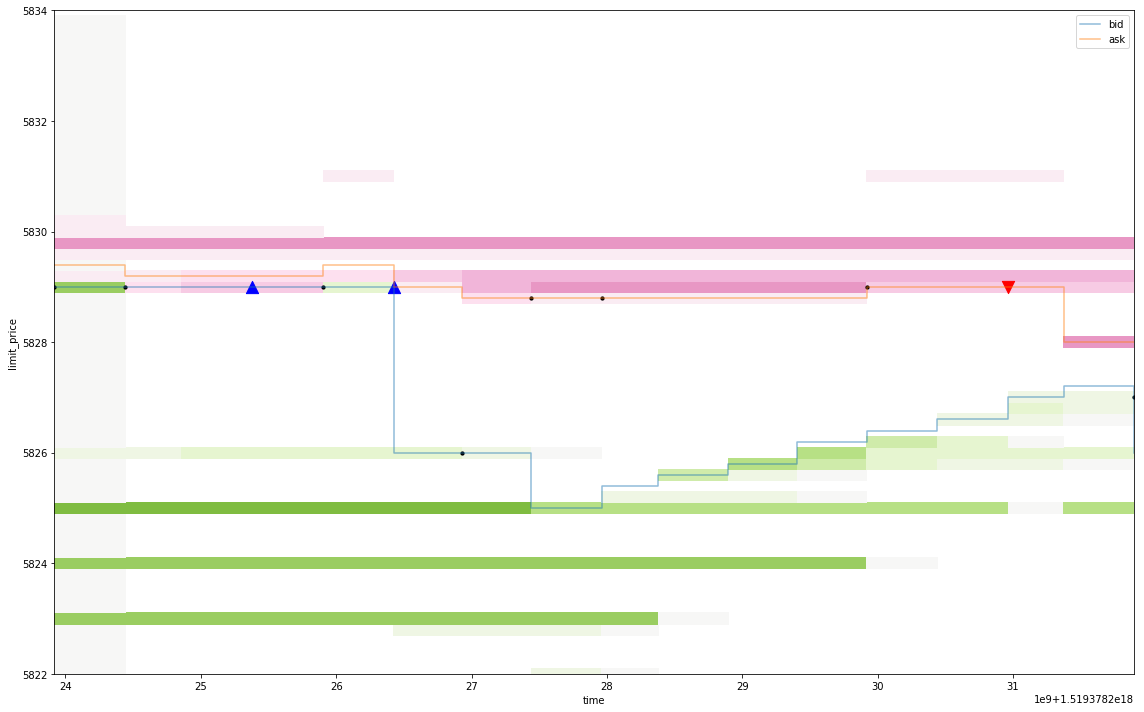

In [23]:
plot_data(
    10,
    reference_data,
    select_subset(trade_summary, time_0, time_1),
    select_subset(market_by_price, time_0, time_1),
    select_subset(top_of_book, time_0, time_1),
    create_order,
    select_subset(order_update, time_0, time_1))

### Extend the view to include the completion of the sell order

In [24]:
time_0, time_1 = get_range(trade_summary, 1, 100)
time_0, time_1

(1519378221872000000, 1519378309891000000)

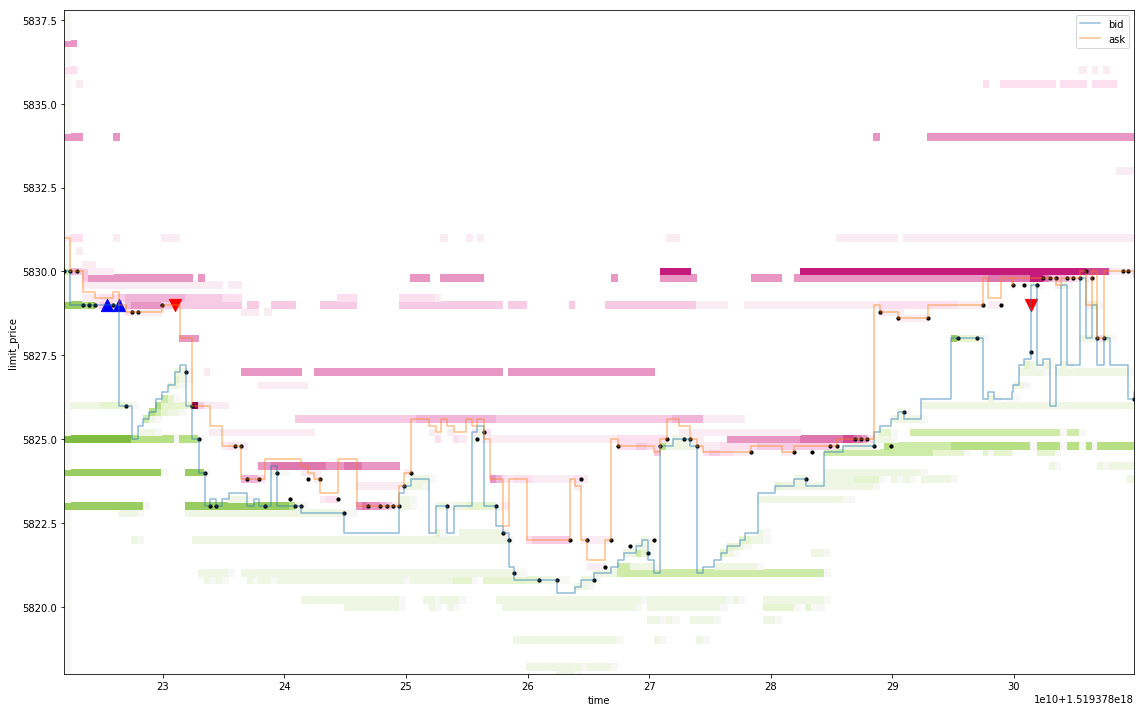

In [25]:
plot_data(
    10,
    reference_data,
    select_subset(trade_summary, time_0, time_1),
    select_subset(market_by_price, time_0, time_1),
    select_subset(top_of_book, time_0, time_1),
    create_order,
    select_subset(order_update, time_0, time_1))

### Zoom in on the sell order being filled

* Best bid crosses the resting order

In [26]:
time_0, time_1 = get_range(trade_summary, 80, 90)
time_0, time_1

(1519378296952000000, 1519378303459000000)

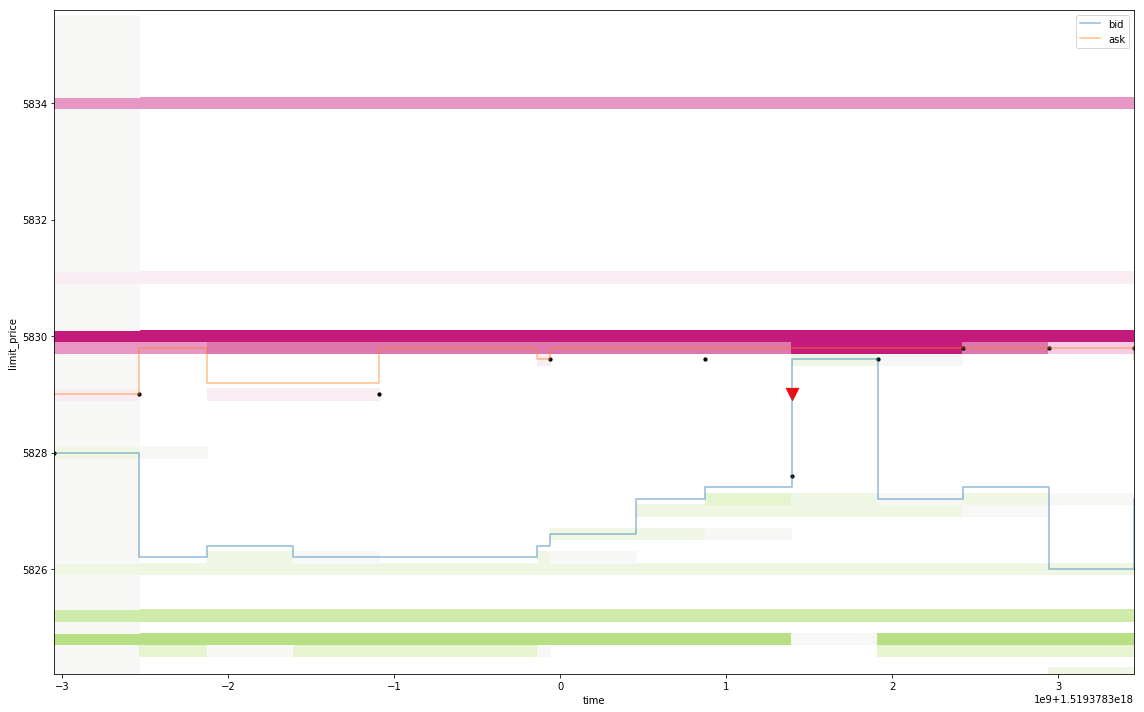

In [27]:
plot_data(
    10,
    reference_data,
    select_subset(trade_summary, time_0, time_1),
    select_subset(market_by_price, time_0, time_1),
    select_subset(top_of_book, time_0, time_1),
    create_order,
    select_subset(order_update, time_0, time_1))